# Empirical data analysis

This notebook will perform the necessary anlysis to find the best parameters for the creation of the empirical network.
The parameter to be found are the `minimum similarity`, that will say whether an article has influenced another, and `maximum time distance` between tow similar articles

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn
from pathlib import Path
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
seaborn.set_style("whitegrid")

## These following have to be customized
PATH_TO_DATA = Path('../data')
# number of days of collection of articles
N_DAYS = 30
# for joblib multithreading
N_THREADS = -1

## Data importation

In [2]:
files = [
    'all_stories.json',
    'word_matrix.json',
    'np_docvs_norm.npz',
    'dists_triu.csv',
    'info_df.csv',
    ]
imgs = [
    '3Dhyperparameter_grid_search.png',
    'time_influence_range.png',
    'time_influence_range_violinplot.png',
    'similarity_dist_pairwise.png',
    'similarity_dist_most_similar.png',
    '2Dhyperparameter_grid_search.png',
    ]
stories = [
    'world_russia',
    'world_norway',
    'world_capitol_hill',
]
story_to_elaborate = 0
with open(PATH_TO_DATA/stories[story_to_elaborate]/files[4]) as csv_file:
    # dropping autospawned 'Unnamed: 0' column, and unecessary (since they are ordered already) 'article_id' column
    info_df = pd.read_csv(csv_file).drop(['Unnamed: 0'], 1)
info_df = info_df.rename(columns={'id': 'article_id'})
info_df['timestamp'] = pd.to_datetime(info_df.timestamp)
print(info_df.head())
with open(PATH_TO_DATA/stories[story_to_elaborate]/files[3]) as csv_file:
    # dropping autospawned 'Unnamed: 0' column, and unecessary (since they are ordered already) 'article_id' column
    dists_triu = pd.read_csv(csv_file, sep=',', header=None)
dists_triu = dists_triu.values
print(dists_triu.shape)

/tmp/ipykernel_11021/2152746974.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  info_df = pd.read_csv(csv_file).drop(['Unnamed: 0'], 1)


   index  article_id           timestamp  source
0      0  1926391701 2021-05-10 00:00:00  278722
1      0  1926430980 2021-05-10 00:00:00   20270
2      0  1926386660 2021-05-10 00:01:35    1123
3      0  1926388426 2021-05-10 00:01:35   63091
4      0  1926416043 2021-05-10 00:58:55    1123
(3323, 3323)


In [3]:
list_ids = list(info_df['article_id'])
len(list_ids)

3323

Functions for building the graph.

In [29]:
def get_index(
    data, # DataFrame containing articles info
    timestamp, # time of current article
    similarities, # similarities of the current article
    max_dt, # max dt (in hours) for two articles to be linked
    min_dt, # min dt (in hours) for two articles to be linked
    min_similarity, # minimum cos sim distance for two articles to be linked
    outs, # current list of excluded articles
    ):
    while True:
        # get the maximum similarity w.r.t. older articles
        similarity = max(similarities)
        # get the index of such max similar article
        index = similarities.index(similarity)
        # get dt in terms of hours
        dt = (timestamp - data['timestamp'][index]).total_seconds() / 3600 / 24
        # similarity threshold
        if similarity < min_similarity:
            # return None to add index to outs
            return None
        # continue if article is in outs or its distant in time
        elif index in outs or dt > max_dt or dt <= min_dt:
            similarities[index] = 0
        # pass condition
        else:
            return index

def create_graph(
    dists_triu, # similarity matrix
    data, # DataFrame containing articles info
    time_max: int = 168, # max dt (in hours) for two articles to be linked
    time_min: int = 6, # min dt (in hours) for two articles to be linked
    sim_min: float = 0.8, # minimum cos sim distance for two articles to be linked
    ):
    # max number of nodes
    n_articles = dists_triu.shape[0]
    # instantiate the directed graph
    G = nx.Graph()
    # adding the first node
    G.add_node(0, step=0,
               date=data['timestamp'][0],
               domain=data['source'][0],
               _id=data['article_id'][0],
               children=[])
    # instatiating elimination list
    outs = []
    # loop on the other articles
    for i in range(1, n_articles):
        # get time of current article
        pub_i = data['timestamp'][i]
        # get similarities
        column = list(dists_triu[:, i])
        # get index of an article related to the current one
        index = get_index(data, pub_i, column, time_max, time_min, sim_min, outs)
        # if a relation was found
        if index != None:
            # if the related article has not already been inserted, insert it
            if index not in G.nodes():
                G.add_nodes_from([(index, {
                    'timestamp': data['timestamp'][index],
                    'source': data['source'][index],
                    'id': data['article_id'][index],
                })])
            # if the current article has not already been inserted, insert it
            if i not in G.nodes():
                G.add_nodes_from([(i, {
                    'timestamp': data['timestamp'][i],
                    'source': data['source'][i],
                    'id': data['article_id'][i]
                })])
            # linking the nodes
            G.add_edge(index, i)
        # if a relation wa not found
        else:
            # add current article to elimination listS
            outs.append(i)
    # return the graph
    return G

Function for getting the giant componend of a created graph.

In [5]:
def get_gc_nodes(
    params
):
    G = create_graph(dists_triu, info_df, time_max=params[1], sim_min=params[0])
    Gcc = sorted((G.subgraph(c) for c in nx.connected_components(G)), key = len, reverse=True)
    G0 = Gcc[0]       
    return G0.number_of_nodes()/dists_triu.shape[0]

## Hyperparameter grid search

Check giant component fraction against time window and similarity threshold.
Setting the grid to search in.

In [30]:
MIN_SIM, MAX_SIM, DELTA_SIM = 0.70, 1.0, 0.01
sims = np.arange(MIN_SIM, MAX_SIM, DELTA_SIM)
MIN_GAM, MAX_GAM, DELTA_GAM = 10*24, 18*24, 24 # in hours
gammas = np.arange(MIN_GAM, MAX_GAM, DELTA_GAM)
g = np.meshgrid(sims, gammas)
params = np.vstack(map(np.ravel, g)).T
params.shape

/tmp/ipykernel_11021/793309512.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  params = np.vstack(map(np.ravel, g)).T


(248, 2)

Running the computations of the graphs

In [ ]:
params_iterator = tqdm(
    params,
    leave=True,
    unit='hyperparameters',
)

list_of_gcn = Parallel(n_jobs=N_THREADS)(delayed(get_gc_nodes)(i) for i in params_iterator)

Plotting the results.

In [10]:
%matplotlib qt

In [11]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

#ax.scatter(g[0], g[1], list_of_gcn)
# Plot the surface.
Z =  np.array(list_of_gcn).reshape(g[0].shape)
surf = ax.plot_surface(g[0], g[1], Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_title("Hyperparameter grid search")
ax.set_xlabel("similarity threshold")
ax.set_ylabel("time window (hours)")
ax.set_zlabel("fraction of giant component")

plt.show()
plt.savefig(PATH_TO_DATA/stories[story_to_elaborate]/imgs[0])

## Time matrix analysis

We want to set the time windows such that 95% of articles is accounted for influence.

In [6]:
def create_time_dif(timestamps):
    times_dif = np.full(dists_triu.shape, 300.0)
    #times_dif = np.triu(times_dif)
    timestamps_iterator = tqdm(
        timestamps.copy(),
        leave=True,
        unit='timestamps',
    )
    for l, i in enumerate(timestamps_iterator):
        c = l
        for k, j in enumerate(timestamps[l:]):
            day_dif = abs((i-j).total_seconds()/3600)/24.
            times_dif[l,c] = day_dif
            c+=1
    np.fill_diagonal(times_dif,0.0)
    return times_dif

In [8]:
difs = create_time_dif(list(info_df['timestamp']))

  0%|          | 0/3323 [00:00<?, ?timestamps/s]

array([[0.00000000e+00, 0.00000000e+00, 1.09953704e-03, ...,
        3.19682755e+01, 3.19871759e+01, 3.19889931e+01],
       [3.00000000e+02, 0.00000000e+00, 1.09953704e-03, ...,
        3.19682755e+01, 3.19871759e+01, 3.19889931e+01],
       [3.00000000e+02, 3.00000000e+02, 0.00000000e+00, ...,
        3.19671759e+01, 3.19860764e+01, 3.19878935e+01],
       ...,
       [3.00000000e+02, 3.00000000e+02, 3.00000000e+02, ...,
        0.00000000e+00, 1.89004630e-02, 2.07175926e-02],
       [3.00000000e+02, 3.00000000e+02, 3.00000000e+02, ...,
        3.00000000e+02, 0.00000000e+00, 1.81712963e-03],
       [3.00000000e+02, 3.00000000e+02, 3.00000000e+02, ...,
        3.00000000e+02, 3.00000000e+02, 0.00000000e+00]])

(array([  68., 1513.,  393.,  155.,   90.,   75.,  104.,   55.,   42.,
          26.,   23.,   21.,   29.,   22.,   96.,   37.,   35.,   31.,
           8.,   54.,   21.,   29.,   27.,   20.,   32.,   97.,   28.,
          37.,   53.,   17.,   26.,   59.]),
 array([ 0.        ,  0.99965603,  1.99931207,  2.9989681 ,  3.99862413,
         4.99828016,  5.9979362 ,  6.99759223,  7.99724826,  8.9969043 ,
         9.99656033, 10.99621636, 11.9958724 , 12.99552843, 13.99518446,
        14.99484049, 15.99449653, 16.99415256, 17.99380859, 18.99346463,
        19.99312066, 20.99277669, 21.99243273, 22.99208876, 23.99174479,
        24.99140082, 25.99105686, 26.99071289, 27.99036892, 28.99002496,
        29.98968099, 30.98933702, 31.98899306]),
 <BarContainer object of 32 artists>)

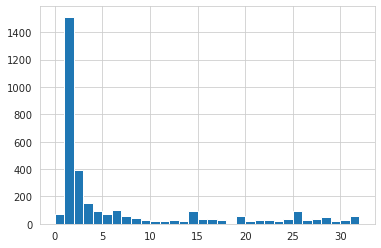

In [10]:
plt.figure(figsize=(15, 6))
occ, _ = plt.hist(difs[0], bins='auto')
plt.title('Distribution of time distances w.r.t. the first published articles')
plt.xlabel('time (days)')
plt.ylabel('number of articles')
plt.show()
plt.figure(figsize=(15, 6))
plt.hist(np.diag(difs, k=1), bins=len(occ))
plt.title('Distribution of time distances w.r.t. the previous published articles')
plt.xlabel('time (days)')
plt.ylabel('number of articles')
plt.show()

In [71]:
len(np.where(difs[0]<=0)[0])

2

In [78]:
df = pd.DataFrame()

SIM_THRESHOLD = 0.98

n_articles = dists_triu.shape[0]

min_dif_temp = 24/24
initial_infected = len(np.where(difs[0]<=min_dif_temp)[0])

days_iterator = tqdm(
    range(1, N_DAYS+1),
    leave=True,
    unit='days',
)
# TODO: check this
# loop on days of the study
for days in days_iterator:
    days_column = []
    # loop on articles
    # for i in range(dists_triu.shape[0]-1):
    #     c = i+1
    for i in range(initial_infected, n_articles-initial_infected):
        c=i
        # similarity distances for article c
        dists_column = dists_triu[:,c]
        # time distances for article c
        difs_column = difs[:,c]
 
        # articles that have time difference minor or equal that 'days'
        difs_ok = np.where(((difs_column <= days) & (difs_column > min_dif_temp)))[0]
        # if there are those articles
        if difs_ok.size != 0:
            # get similarity distances of those articles
            dists_ok = [dists_column[i] for i in difs_ok]
            # get the most similar articles
            max_sim = max(dists_ok)
            # if this is not similar enough
            if max_sim < SIM_THRESHOLD:
                # append nan
                days_column.append(np.nan)
            else:
                # append time difference
                index = difs_ok[dists_ok.index(max_sim)]
                days_column.append(difs_column[index])
        else:
            days_column.append(np.nan)
    df[days] = days_column
df.head()

  0%|          | 0/30 [00:00<?, ?days/s]

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


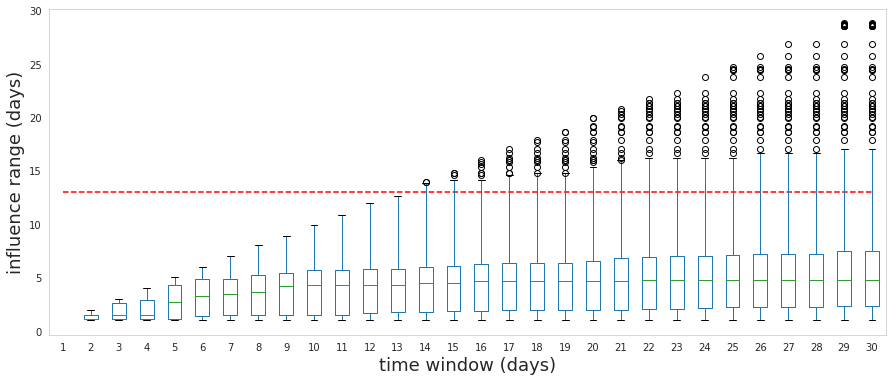

In [79]:
plt.figure(figsize=(15, 6))
plt.plot(np.arange(1, 31), 30*[13], '--', c='r')
df.boxplot(whis=95/50)
plt.xlabel('time window (days)',fontsize=18)
plt.ylabel('influence range (days)', fontsize=18)
plt.grid(False)
plt.savefig(PATH_TO_DATA/stories[story_to_elaborate]/imgs[1])

In [28]:
TIME_THRESHOLD = 13 # in days

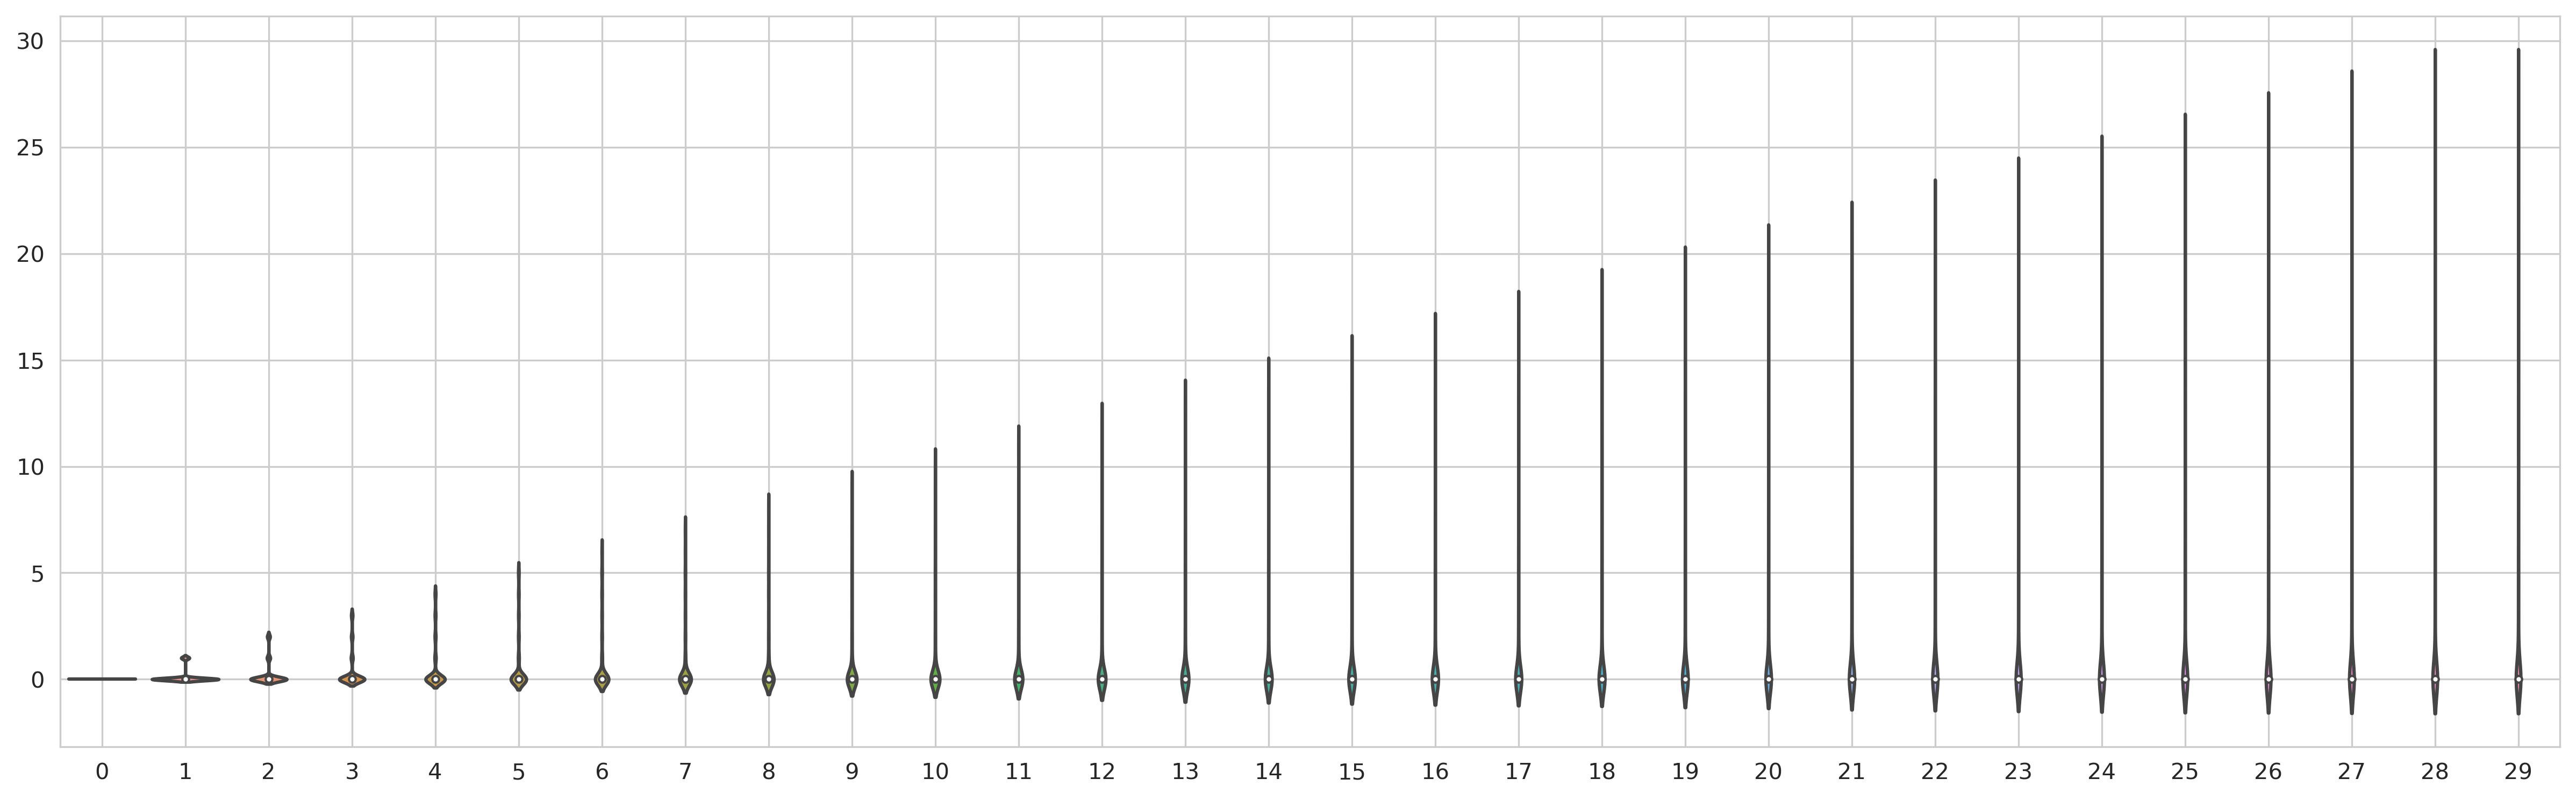

In [34]:
plt.figure(figsize=(20, 6), dpi=300)
seaborn.violinplot(data=df.dropna())
plt.grid(True)
plt.savefig(PATH_TO_DATA/stories[story_to_elaborate]/imgs[2])

## Similarity analysis

We want to set a similarity threshold such that the giant component of the network is populated by more than 80% of articles.

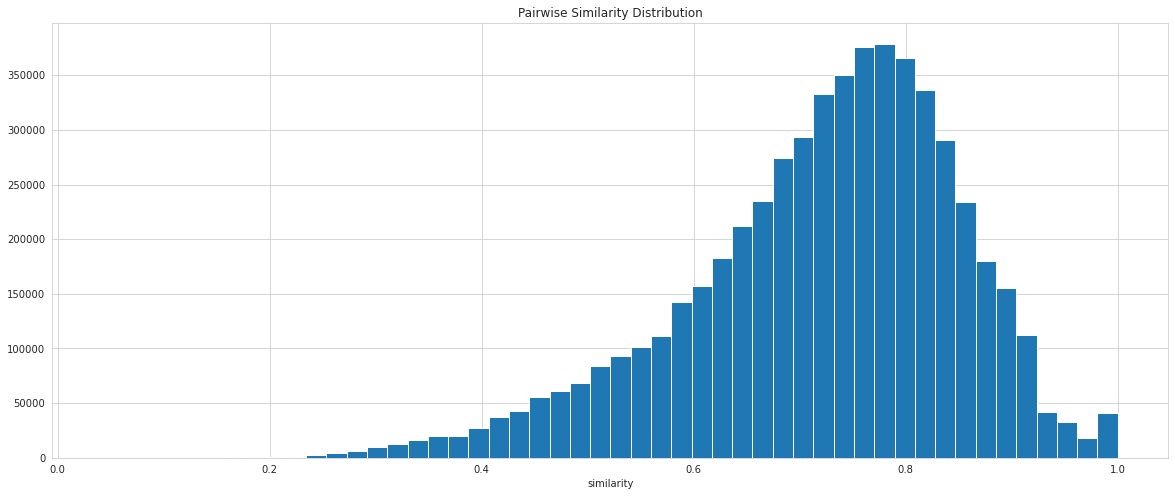

<Figure size 432x288 with 0 Axes>

In [64]:
A = dists_triu.flatten()
fig = plt.figure(figsize=(20,8))
plt.hist(A[A>0], bins=50)
plt.title('Pairwise Similarity Distribution')
plt.xlabel('similarity')
plt.show()
plt.savefig(PATH_TO_DATA/stories[story_to_elaborate]/imgs[3])

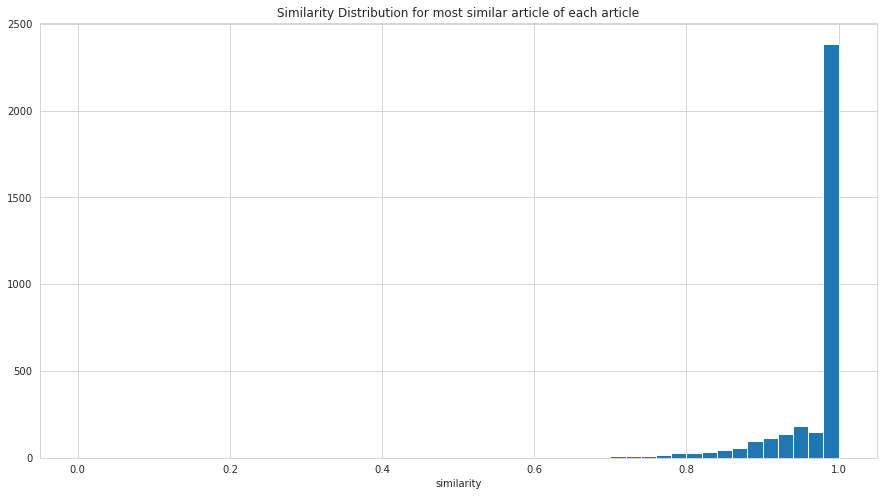

<Figure size 432x288 with 0 Axes>

In [65]:
fig = plt.figure(figsize=(15,8))
plt.hist(np.max(dists_triu, axis=1), bins=50)
plt.title('Similarity Distribution for most similar article of each article')
plt.xlabel('similarity')
plt.show()
plt.savefig(PATH_TO_DATA/stories[story_to_elaborate]/imgs[4])

In [ ]:
MIN_SIM, MAX_SIM, DELTA_SIM = 0.70, 1.0, 0.01
sims_1 = np.arange(MIN_SIM, MAX_SIM, DELTA_SIM)
TIME_THRESHOLD = 14 # in days
params = [[s, TIME_THRESHOLD] for s in sims_1]
sim_thresholds = tqdm(
    params,
    leave=True,
    unit='similarities',
)
list_of_gcn_1 = Parallel(n_jobs=N_THREADS)(delayed(get_gc_nodes)(i) for i in sim_thresholds)

In [ ]:
fig = plt.figure(figsize=(15,8))
plt.plot(sims_1, list_of_gcn_1)
plt.xlabel('similarity treshold')
plt.ylabel('fraction of articles in the giant component')
plt.grid(True)
plt.show()

In [ ]:
MIN_SIM, MAX_SIM, DELTA_SIM = 0.50, 1.0, 0.01
sims_2 = np.arange(MIN_SIM, MAX_SIM, DELTA_SIM)
TIME_THRESHOLD = 14 # in days
params = [[s, TIME_THRESHOLD] for s in sims_2]
sim_thresholds = tqdm(
    params,
    leave=True,
    unit='thresholds',
)
list_of_gcn_2 = Parallel(n_jobs=N_THREADS)(delayed(get_gc_nodes)(i) for i in sim_thresholds)

In [ ]:
fig1 = plt.figure(figsize=(15,8))
ax1 = fig1.add_subplot(111)
ax1.plot(sims_2, list_of_gcn_2)
plt.xlabel('similarity treshold', fontsize=19)
plt.ylabel('fraction of articles in the giant component', fontsize=19)
ax2 = plt.axes([.2, .2, .25, .3])
ax2.plot(sims_1, list_of_gcn_1)
plt.show()
plt.savefig(PATH_TO_DATA/stories[story_to_elaborate]/imgs[5])

In [ ]:
SIM_THRESHOLD = 0.75